In [1]:
!pip install einops
!pip install fancy_einsum
!pip install datasets==2.14.1 transformers==4.32.0 -q

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import einops
import numpy as np
import math
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW
import pandas as pd
import tqdm
from fancy_einsum import einsum

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
@dataclass
class configure_model():
  dim:int = 768
  eps:float = 1e-5
  vocab:int = 50257
  init_stddev:float = 0.02
  max_word:int = 1024
  n_head:int = 12
  d_head:int = 64
  d_mlp:int = 3072
  n_layers:int = 12
 
  
    
configure = configure_model()


In [4]:
class Layer_Norm(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.configure = configure
    self.w = nn.Parameter(torch.ones(configure.dim))
    self.b = nn.Parameter(torch.zeros(configure.dim))

  def forward(self,in_tensor):
   
    #taking mean along the dimension
    # batch_size --> number of sentences taken, pos --> number of words in sequence , dim --> size of the embedding layer
    #z=(x-mu)
    z= in_tensor - einops.reduce(in_tensor,"batch_size seq_len dim -> batch_size seq_len 1","mean")

    #variance+eps
    var = (einops.reduce(z**2,"batch_size seq_len dim -> batch_size seq_len 1","mean")+configure.eps).sqrt()

    #normalize
    l_norm = self.w*(z/var)+self.b

    return l_norm

In [5]:
class embed_input(nn.Module):
  def __init__(self,configure):
    super().__init__()

    self.embed_w = nn.Parameter(torch.empty((configure.vocab,configure.dim)))

    #changing the standard deviation to 0.02(mentioned in GPT2 original paper)
    nn.init.normal_(self.embed_w, std=configure.init_stddev)

  def forward(self,in_tokens):
    #retrieve the rows from corresponding tokens
    return self.embed_w[in_tokens,:]


Rotary position embeddings can be obtained by using following formula.
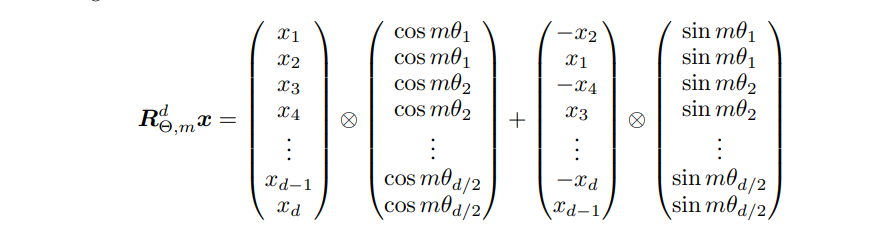


where θ is {  θi= pow(10000,-(2-i)/d), i range[1,d/2]} 

In [6]:
def find_sinusoid(head_dim,seq_len):
    if head_dim%2==0:
        theta_max = 10000
        theta_pow = torch.arange(0,head_dim,2)
        thetas = ((theta_max)**(theta_pow/head_dim)).to(device)
        thetas = 1.0/thetas
        m=torch.arange(seq_len,device=device)
        complex_f = torch.outer(m,thetas).float()
        complex_f = torch.polar(torch.ones_like(complex_f),complex_f)
        return complex_f
    
def rotary_embedding(x,head_dim,seq_len):
    sinusoids = find_sinusoid(head_dim,seq_len)
#     print(f"sinusoids:{sinusoids.shape}")

    x_f = x.float().reshape(*x.shape[:-1],-1,2)
    x_complex = torch.view_as_complex(x_f)
#     print(f"x_complex:{x_complex.shape}")

    sinusoids = sinusoids.unsqueeze(0).unsqueeze(2)
#     print(f"reshaped sinusoids:{sinusoids.shape}")

    x_rotated = x_complex * sinusoids
    x_out = torch.view_as_real(x_rotated)
    x_out = x_out.reshape(*x.shape)
    x_out = x_out.type_as(x).to(device)
    return x_out

Grouped query attention is proposed to adapt both good performance and computational efficiency by reducing the number of heads in keys and values to half of the number of heads in Queries.
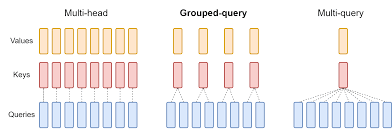

In [7]:
class grouped_attn(nn.Module):
    def __init__(self,configure):
        super().__init__()
        self.configure = configure
        
        
        #two heads mapped to one key,
        self.KV_head = configure.n_head//2
        
        #ratio b/w no.of q_heads and no.of KV heads
        self.ratio = 2
        
        #initalizing weights of queries
        self.w_q = nn.Parameter(torch.empty((configure.n_head,configure.dim,configure.d_head)))
        nn.init.normal_(self.w_q, std=configure.init_stddev)
        self.b_q = nn.Parameter(torch.zeros(configure.n_head,configure.d_head))

        #initializing weights of keys
        self.w_k = nn.Parameter(torch.empty((self.KV_head,configure.dim,configure.d_head)))
        nn.init.normal_(self.w_k, std=configure.init_stddev)
        self.b_k = nn.Parameter(torch.zeros(self.KV_head,configure.d_head))

        #initializing weights of values
        self.w_v = nn.Parameter(torch.empty((self.KV_head,configure.dim,configure.d_head)))
        nn.init.normal_(self.w_v, std=configure.init_stddev)
        self.b_v = nn.Parameter(torch.zeros(self.KV_head,configure.d_head))
        
        #initializing output weights
        self.w_o = nn.Parameter(torch.empty((self.KV_head,configure.d_head,configure.dim)))
        nn.init.normal_(self.w_o, std=configure.init_stddev)
        self.b_o = nn.Parameter(torch.zeros(configure.dim))

        self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32, device="cuda"))
        

    def apply_causal_mask(self, attn_scores):

            mask = torch.triu(torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device), diagonal=1).bool()
            attn_scores.masked_fill_(mask, self.IGNORE)
            return attn_scores

    def forward(self,norm_input):
        
        batch,seq_len,_ = norm_input.shape
        q = einsum("batch query_pos dim, n_head dim d_head -> batch query_pos n_head d_head", norm_input, self.w_q) + self.b_q
        k = einsum("batch key_pos dim, kv_head dim d_head -> batch key_pos kv_head d_head", norm_input, self.w_k) + self.b_k
        
        q_rope = rotary_embedding(q,configure.d_head,seq_len) 
        k_rope = rotary_embedding(k,configure.d_head,seq_len) 
        
        #n--> r*h
        q_rope = rearrange(q_rope,"b s (r h) d -> b s r h d",r=self.ratio)
        attn = einsum("batch query_pos ratio kv_head d_head, batch key_pos kv_head d_head -> batch kv_head query_pos key_pos", q_rope, k_rope) 
        
        attn = attn/(math.sqrt(self.configure.d_head))
        attn = self.apply_causal_mask(attn)

        
        v = einsum("batch key_pos dim, kv_head dim d_head -> batch key_pos kv_head d_head", norm_input, self.w_v) + self.b_v
        attn_prob = attn.softmax(dim=-1)

        att = einsum("batch n_head query_pos key_pos, batch key_pos n_head d_head -> batch query_pos n_head d_head",attn_prob,v)
        out = einsum("batch query_pos n_head d_head, n_head d_head dim -> batch query_pos dim", att, self.w_o)+self.b_o
        return out


In [8]:

class mlp(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.w1 = nn.Parameter(torch.empty((configure.dim,configure.d_mlp)))
    nn.init.normal_(self.w1, std=configure.init_stddev)
    self.b1 = nn.Parameter(torch.zeros(configure.d_mlp))

    self.w2 = nn.Parameter(torch.empty((configure.d_mlp,configure.dim)))
    nn.init.normal_(self.w2, std=configure.init_stddev)
    self.b2 = nn.Parameter(torch.zeros(configure.dim))

    self.gelu = nn.GELU()

  def forward(self, x):
     
     o1 = self.gelu(einsum("batch pos dim, dim d_mlp -> batch pos d_mlp", x, self.w1)+self.b1)
     o2 = einsum("batch pos d_mlp, d_mlp dim -> batch pos dim", o1,self.w2)+self.b2
     return o2

In [9]:
class GPT2_block_modified(nn.Module):
  def __init__(self,configure):
    super().__init__()
    
    self.l1 = Layer_Norm(configure)
    self.self_att = grouped_attn(configure)
    self.l2 = Layer_Norm(configure)
    self.mlp_out = mlp(configure)

  def forward(self,embeddings):
    norm_embeddings = self.l1(embeddings)
    self_att_out = self.self_att(norm_embeddings)
    out1 = embeddings+self_att_out

    out_embeddings_norm = self.l2(out1)
    mlp_out = self.mlp_out(out_embeddings_norm)
    out2 = out1 + mlp_out 

    return out2

In [10]:
class logits_layer(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.w1 = nn.Parameter(torch.empty((configure.dim,configure.vocab)))
    nn.init.normal_(self.w1, std=configure.init_stddev)
    self.b1 = nn.Parameter(torch.zeros((configure.vocab), requires_grad=False))

  def forward(self, gpt_out):

    logits = einsum("batch position dim, dim vocab -> batch position vocab", gpt_out, self.w1) + self.b1
    return logits


In [11]:
class GPT2_modified(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.embed_token = embed_input(configure)
    self.blocks = nn.ModuleList([GPT2_block_modified(configure) for _ in range(configure.n_layers)])
    self.l = Layer_Norm(configure)


  def forward(self,tokens):
    out = self.embed_token(tokens)


    for block in self.blocks:
      out = block(out)

    norm_out = self.l(out)
    

    return norm_out

In [12]:
model = GPT2_modified(configure)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params )

113027328


In [13]:

class custom_dataset(Dataset):
    def __init__(self, tokenizer, max_length=1024,num_rows=50):
        super().__init__()

        self.dataset_path = '/kaggle/input/all-the-news/articles1.csv'
        self.dataframe = pd.read_csv(self.dataset_path,nrows=num_rows)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Tokenize each entry and add it to the list
        self.content_list = [self.tokenize(content) for content in self.dataframe['content']]

    def tokenize(self, text):
        # Encode the text into tokens with truncation if necessary
        tokens = self.tokenizer.encode(text, max_length=self.max_length, truncation=True)
        return tokens

    def __len__(self):
        return len(self.content_list)
    
    def __getitem__(self, idx):
        return torch.tensor(self.content_list[idx])

In [14]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
custom_dataset = custom_dataset(tokenizer)
data_loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)

In [15]:
#to verify the working
get_logits = logits_layer(configure)
for idx, batch in tqdm.tqdm(enumerate(data_loader)):
        tokens = batch.to(device)
        output = model(tokens)
        get_logits = get_logits.to(output.device)
        logits = get_logits(output)
        argmax = torch.argmax(logits, dim=-1)
        print(tokenizer.decode(argmax.tolist()[0]))
        break

0it [00:03, ?it/s]

learningijk James Xi Mercuryarrison hearing inspiration hearingnewsMRMRaminsnews downrightnewsnews NVIDIAnewsnewsamins THEM hearingdfxaci hearingaciaci213aci overwhelmingly���� funernews story�������� intro downright story downright downright�� hearing hearing pawnamins���� pawn pawn�� story downright downright pawn�� pawn hearing pawnasonable downright hearing strand�� pawn�� downright�� pawnasonable pawn��otallyuren Watching pawn pawn downright�� James Opposition pawn pawn pawn�� pawn pawn James pawn acceleration pawn Watching pawn Watching�� James commercials pawn correctness James pawn pawn hearing pawn pawn�� pawn pawn pawn pawn pawnBorn pawn James pawn pawn pawn assorted pawn pawn assorted pawn pawn pawn correctness turtles�� pawn pawn pawn pawn pawn assorted pawn pawnarette pawn pawn pawn pawn pawn pawn pawn Opposition PIT pawn pawn pawn pawn pawn pawn correctness pawn pawn Such pawn pawn pawn pawn pawn pawn pawn pawn pawn pawn pawn explode pawn intro pawn pawn pawn James slogan